<a href="https://colab.research.google.com/github/dany-roman/project_4_stock_analysis/blob/main/stock_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance -q
!pip install keras-tuner -q

import pandas as pd
import sklearn as skl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import linregress
from google.colab import files
import yfinance as yf

Import Kaggle Training Data

In [2]:
amd_file = "https://raw.githubusercontent.com/dany-roman/project_4_stock_analysis/main/data/AMD_stock.csv"
google_file = "https://raw.githubusercontent.com/dany-roman/project_4_stock_analysis/main/data/Google_stock.csv"
hp_file = "https://raw.githubusercontent.com/dany-roman/project_4_stock_analysis/main/data/HP_stock.csv"
intel_file = "https://raw.githubusercontent.com/dany-roman/project_4_stock_analysis/main/data/Intel_stock.csv"
tesla_file = "https://raw.githubusercontent.com/dany-roman/project_4_stock_analysis/main/data/Tesla_stock.csv"

amd = pd.read_csv(amd_file)
google = pd.read_csv(google_file)
hp = pd.read_csv(hp_file)
intel = pd.read_csv(intel_file)
tesla = pd.read_csv(tesla_file)

amd = pd.DataFrame(amd)
google = pd.DataFrame(google)
hp = pd.DataFrame(hp)
intel = pd.DataFrame(intel)
tesla = pd.DataFrame(tesla)

Data Processing for Neural Network

In [3]:
def cal_test_data(df):
    hc = df['High'] - df['Low']
    oc = df['Close'] - df['Open']
    m_avg_7 = hc.rolling(7, min_periods=0).mean() 
    m_avg_14 = hc.rolling(14, min_periods=0).mean()
    m_avg_21 = hc.rolling(21, min_periods=0).mean()
    m_std_7 = df['Close'].rolling(7, min_periods=0).std()
    close = df['Close']
    test_data = {
        "High-Low Price": hc,
        "Close-Open Price": oc,
        "7-day m_avg": m_avg_7,
        "14-day m_avg": m_avg_14,
        "21-day m_avg": m_avg_21,
        "7-day m_std": m_std_7,
        "Close": close,
    }
    test_df = pd.DataFrame(test_data)
    test_df = test_df.fillna(0)
    return test_df

In [4]:
amd_df = cal_test_data(amd)
google_df = cal_test_data(google)
hp_df = cal_test_data(hp)
intel_df = cal_test_data(intel)
tesla_df = cal_test_data(tesla)

google_df.head()
# pred_amd_df = pred_amd_df.fillna(0)
# pred_google_df = pred_google_df.fillna(0)
# pred_hp_df = pred_hp_df.fillna(0)
# pred_intel_df = pred_intel_df.fillna(0)
# pred_tesla_df = pred_tesla_df.fillna(0)

,High-Low Price,Close-Open Price,7-day m_avg,14-day m_avg,21-day m_avg,7-day m_std,Close
0,13.830017,7.330017,13.830017,13.830017,13.830017,0.000000,786.140015
1,8.180054,-1.459961,11.005035,11.005035,11.005035,0.537408,786.900024
2,9.459961,7.940002,10.490011,10.490011,10.490011,4.346769,794.020020
3,15.696045,10.890015,11.791519,11.791519,11.791519,9.271221,806.150024
4,7.135986,0.250000,10.860413,10.860413,10.860413,10.004890,806.650024


Import Recent Stock Data from Yahoo Finance

In [5]:
amd = yf.Ticker("AMD")
google = yf.Ticker("GOOG")
hp = yf.Ticker("HPQ")
intel = yf.Ticker("INTC")
tesla = yf.Ticker("TSLA")

In [6]:
AMD = amd.history(period="max").drop(columns = ['Dividends','Stock Splits'])
GOOG = google.history(period="max").drop(columns = ['Dividends','Stock Splits'])
HPQ = hp.history(period="max").drop(columns = ['Dividends','Stock Splits'])
INTC = intel.history(period="max").drop(columns = ['Dividends','Stock Splits'])
TSLA = tesla.history(period="max").drop(columns = ['Dividends','Stock Splits'])

Prepare Yahoo Finance Data for Predictions

In [7]:
amd_pdf = cal_test_data(AMD)
google_pdf = cal_test_data(GOOG)
hp_pdf = cal_test_data(HPQ)
intel_pdf = cal_test_data(INTC)
tesla_pdf = cal_test_data(TSLA)

amd_last1y = amd_pdf.tail(365)
google_last1y = google_pdf.tail(365)
hp_last1y = hp_pdf.tail(365)
intel_last1y = intel_pdf.tail(365)
tesla_last1y = tesla_pdf.tail(365)

pred_amd_df = amd_last1y.reset_index()
pred_google_df = google_last1y.reset_index()
pred_hp_df = hp_last1y.reset_index()
pred_intel_df = intel_last1y.reset_index()
pred_tesla_df = tesla_last1y.reset_index()

pred_amd_df.head()

,Date,High-Low Price,Close-Open Price,7-day m_avg,14-day m_avg,21-day m_avg,7-day m_std,Close
0,2020-04-30,2.260002,-1.040001,2.000001,2.556429,2.629048,1.526390,52.389999
1,2020-05-01,2.860001,-1.189999,2.150000,2.557858,2.589524,2.447705,49.880001
2,2020-05-04,2.880001,2.740002,2.325715,2.547143,2.622857,2.406089,52.560001
3,2020-05-05,2.219997,-1.240002,2.305714,2.551429,2.579048,2.216183,52.189999
4,2020-05-06,1.430000,-0.259998,2.260000,2.478572,2.479524,1.702658,52.160000


Neural Network Model

In [8]:
def nn_stock(train_df,predict_df):

  X = train_df.drop('Close', axis=1)
  y = train_df['Close']

  X_train, X_test, y_train, y_test = train_test_split(X, y)

  # Create the Keras Sequential model
  nn_model = tf.keras.models.Sequential()

  # Add our first Dense layer, including the input layer
  nn_model.add(tf.keras.layers.Dense(units=8, activation="relu", input_dim=6))

  # Add our second Dense layer, including the input layer
  nn_model.add(tf.keras.layers.Dense(units=3, activation="relu"))

  # Add the output layer that uses a probability activation function
  nn_model.add(tf.keras.layers.Dense(units=1, activation="linear"))

  # Compile the Sequential model together and customize metrics
  nn_model.compile(loss="mean_squared_error", optimizer="adam",metrics=[tf.keras.metrics.MeanSquaredError()])
  
  fit_model = nn_model.fit(X_train, y_train, epochs=150)
  
  X_pred = predict_df.drop(['Date','Close'],axis=1)
  y_pred = predict_df['Close']
  # date = predict_df['Date']

  predictions = nn_model.predict(X_pred)
  fl_pred = [item for elem in predictions for item in elem]
  pred = {
      # 'Date': date,
      "Actual Close": y_pred,
      "Predicted Close": fl_pred
  }

  pred_df = pd.DataFrame(pred)

  pred_df = pred_df.reset_index()
  pred_df['Close Diff'] = pred_df['Predicted Close'] - pred_df['Actual Close'] 
  pred_df.loc[(pred_df['Close Diff'] < -1), 'Outcome'] = 'Loss'
  pred_df.loc[(pred_df['Close Diff'] >= -1) & (pred_df['Close Diff'] <= 1), 'Outcome'] = 'No Change'
  pred_df.loc[(pred_df['Close Diff'] > 1), 'Outcome'] = 'Gain'
  pred_df = pred_df.rename({"index":"Day"}, axis=1)
  pred_df = pred_df.sort_values('Day')

  return pred_df

Predict Tesla Stock

In [9]:
pred_df = nn_stock(tesla_df,pred_tesla_df)
pred_df
# pred_df.to_csv("predictions_tesla.csv", index=False, header=True)
# files.download("predictions_tesla.csv")

Epoch 1/150
24/24 [==============================] - 0s 1ms/step - loss: 4190.4316 - mean_squared_error: 4190.4316
Epoch 2/150
24/24 [==============================] - 0s 1ms/step - loss: 4135.0894 - mean_squared_error: 4135.0894
Epoch 3/150
24/24 [==============================] - 0s 1ms/step - loss: 4092.9600 - mean_squared_error: 4092.9600
Epoch 4/150
24/24 [==============================] - 0s 1ms/step - loss: 4061.0122 - mean_squared_error: 4061.0122
Epoch 5/150
24/24 [==============================] - 0s 1ms/step - loss: 4039.9685 - mean_squared_error: 4039.9685
Epoch 6/150
24/24 [==============================] - 0s 1ms/step - loss: 4025.4612 - mean_squared_error: 4025.4612
Epoch 7/150
24/24 [==============================] - 0s 1ms/step - loss: 4014.7734 - mean_squared_error: 4014.7734
Epoch 8/150
24/24 [==============================] - 0s 1ms/step - loss: 4005.8865 - mean_squared_error: 4005.8865
Epoch 9/150
24/24 [==============================] - 0s 1ms/step - loss: 3995.69

,Day,Actual Close,Predicted Close,Close Diff,Outcome
0,0,156.376007,231.887833,75.511826,Gain
1,1,140.264008,241.491806,101.227798,Gain
2,2,152.238007,255.010498,102.772491,Gain
3,3,153.641998,226.408249,72.766251,Gain
4,4,156.516006,223.126801,66.610794,Gain
...,...,...,...,...,...
360,360,781.530029,418.971710,-362.558319,Loss
361,361,780.590027,417.272034,-363.317993,Loss
362,362,782.750000,394.595215,-388.154785,Loss
363,363,793.609985,420.840668,-372.769318,Loss


Text(10, 90, 'y = 0.58x + 193.43')

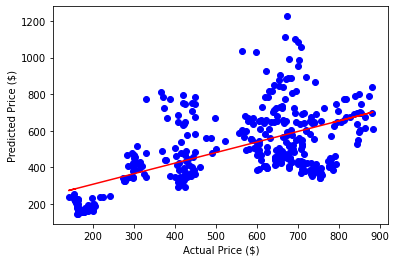

In [10]:
x_values = pred_df['Actual Close']
y_values = pred_df['Predicted Close']
(slope, intercept, rvalue,pvalue,stdeer) = linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x=x_values, y=y_values ,color="blue")
plt.plot(x_values, regress_values,"r-")
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.annotate(line_eq,(10,90), fontsize=10,color="red")

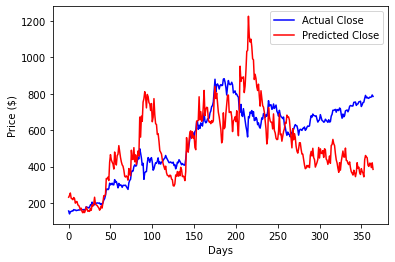

In [11]:
plt.plot(pred_df['Day'],pred_df['Actual Close'], c='b', label='Actual Close')
plt.plot(pred_df['Day'],pred_df['Predicted Close'], c='r', label='Predicted Close')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.show()

Predict AMD stock

In [12]:
pred_df = nn_stock(amd_df,pred_amd_df)
pred_df
# pred_df.to_csv("predictions_amd.csv", index=False, header=True)
# files.download("predictions_amd.csv")

Epoch 1/150
24/24 [==============================] - 0s 1ms/step - loss: 1506.4576 - mean_squared_error: 1506.4576
Epoch 2/150
24/24 [==============================] - 0s 1ms/step - loss: 1504.9043 - mean_squared_error: 1504.9043
Epoch 3/150
24/24 [==============================] - 0s 1ms/step - loss: 1503.3865 - mean_squared_error: 1503.3865
Epoch 4/150
24/24 [==============================] - 0s 1ms/step - loss: 1501.8918 - mean_squared_error: 1501.8918
Epoch 5/150
24/24 [==============================] - 0s 1ms/step - loss: 1500.4091 - mean_squared_error: 1500.4091
Epoch 6/150
24/24 [==============================] - 0s 1ms/step - loss: 1498.9042 - mean_squared_error: 1498.9042
Epoch 7/150
24/24 [==============================] - 0s 1ms/step - loss: 1497.4340 - mean_squared_error: 1497.4340
Epoch 8/150
24/24 [==============================] - 0s 2ms/step - loss: 1495.9323 - mean_squared_error: 1495.9323
Epoch 9/150
24/24 [==============================] - 0s 1ms/step - loss: 1494.44

,Day,Actual Close,Predicted Close,Close Diff,Outcome
0,0,52.389999,3.502264,-48.887735,Loss
1,1,49.880001,3.502264,-46.377737,Loss
2,2,52.560001,3.502264,-49.057737,Loss
3,3,52.189999,3.502264,-48.687735,Loss
4,4,52.160000,3.502264,-48.657736,Loss
...,...,...,...,...,...
360,360,100.339996,3.502264,-96.837732,Loss
361,361,101.809998,3.502264,-98.307734,Loss
362,362,103.639999,3.502264,-100.137735,Loss
363,363,106.449997,3.502264,-102.947733,Loss


Text(10, 90, 'y = 0.0x + 3.5')

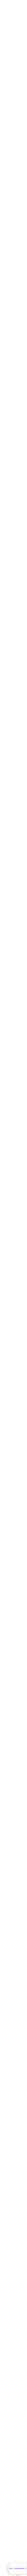

In [13]:
x_values = pred_df['Actual Close']
y_values = pred_df['Predicted Close']
(slope, intercept, rvalue,pvalue,stdeer) = linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x=x_values, y=y_values ,color="blue")
plt.plot(x_values, regress_values,"r-")
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.annotate(line_eq,(10,90), fontsize=10,color="red")

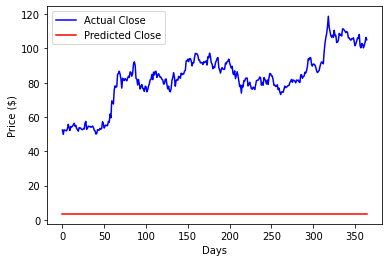

In [14]:
plt.plot(pred_df['Day'],pred_df['Actual Close'], c='b', label='Actual Close')
plt.plot(pred_df['Day'],pred_df['Predicted Close'], c='r', label='Predicted Close')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.show()

Predict Google Stock

In [15]:
pred_df = nn_stock(google_df,pred_google_df)
# pred_df.to_csv("predictions_google.csv", index=False, header=True)
# files.download("predictions_google.csv")

Epoch 1/150
24/24 [==============================] - 0s 1ms/step - loss: 1389571.5000 - mean_squared_error: 1389571.5000
Epoch 2/150
24/24 [==============================] - 0s 1ms/step - loss: 1367918.1250 - mean_squared_error: 1367918.1250
Epoch 3/150
24/24 [==============================] - 0s 1ms/step - loss: 1339406.7500 - mean_squared_error: 1339406.7500
Epoch 4/150
24/24 [==============================] - 0s 1ms/step - loss: 1302570.3750 - mean_squared_error: 1302570.3750
Epoch 5/150
24/24 [==============================] - 0s 1ms/step - loss: 1255708.8750 - mean_squared_error: 1255708.8750
Epoch 6/150
24/24 [==============================] - 0s 1ms/step - loss: 1198598.1250 - mean_squared_error: 1198598.1250
Epoch 7/150
24/24 [==============================] - 0s 1ms/step - loss: 1129800.8750 - mean_squared_error: 1129800.8750
Epoch 8/150
24/24 [==============================] - 0s 1ms/step - loss: 1050368.6250 - mean_squared_error: 1050368.6250
Epoch 9/150
24/24 [=============

Text(0, 0.5, 'Predicted Price ($)')

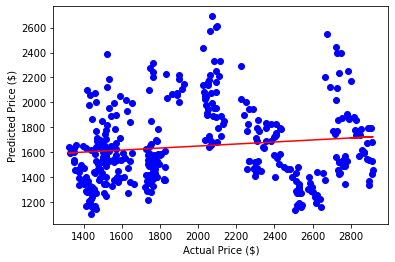

In [16]:
x_values = pred_df['Actual Close']
y_values = pred_df['Predicted Close']
(slope, intercept, rvalue,pvalue,stdeer) = linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x=x_values, y=y_values ,color="blue")
plt.plot(x_values, regress_values,"r-")
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
# plt.annotate(line_eq,fontsize=10,color="red")

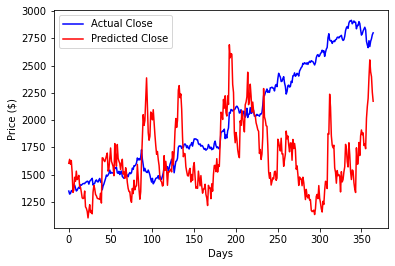

In [17]:
plt.plot(pred_df['Day'],pred_df['Actual Close'], c='b', label='Actual Close')
plt.plot(pred_df['Day'],pred_df['Predicted Close'], c='r', label='Predicted Close')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.show()

Predict HP Stock

In [18]:
pred_df = nn_stock(hp_df,pred_hp_df)
# pred_df.to_csv("predictions_hp.csv", index=False, header=True)
# files.download("predictions_hp.csv")

Epoch 1/150
24/24 [==============================] - 0s 1ms/step - loss: 31767.3730 - mean_squared_error: 31767.3730
Epoch 2/150
24/24 [==============================] - 0s 1ms/step - loss: 31410.9746 - mean_squared_error: 31410.9746
Epoch 3/150
24/24 [==============================] - 0s 1ms/step - loss: 30934.4844 - mean_squared_error: 30934.4844
Epoch 4/150
24/24 [==============================] - 0s 1ms/step - loss: 30289.1309 - mean_squared_error: 30289.1309
Epoch 5/150
24/24 [==============================] - 0s 1ms/step - loss: 29443.6973 - mean_squared_error: 29443.6973
Epoch 6/150
24/24 [==============================] - 0s 1ms/step - loss: 28385.3457 - mean_squared_error: 28385.3457
Epoch 7/150
24/24 [==============================] - 0s 1ms/step - loss: 27132.5293 - mean_squared_error: 27132.5293
Epoch 8/150
24/24 [==============================] - 0s 1ms/step - loss: 25639.0625 - mean_squared_error: 25639.0625
Epoch 9/150
24/24 [==============================] - 0s 1ms/step

Text(0, 0.5, 'Predicted Price ($)')

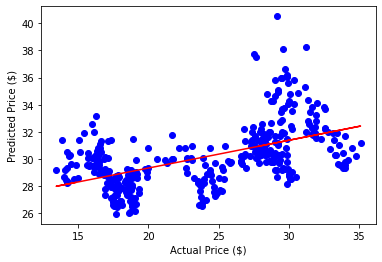

In [19]:
x_values = pred_df['Actual Close']
y_values = pred_df['Predicted Close']
(slope, intercept, rvalue,pvalue,stdeer) = linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x=x_values, y=y_values ,color="blue")
plt.plot(x_values, regress_values,"r-")
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
# plt.annotate(line_eq, fontsize=10,color="red")

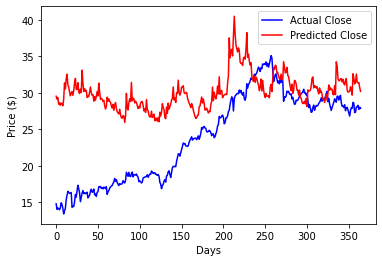

In [20]:
plt.plot(pred_df['Day'],pred_df['Actual Close'], c='b', label='Actual Close')
plt.plot(pred_df['Day'],pred_df['Predicted Close'], c='r', label='Predicted Close')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.show()

Predict Intel Stock

In [21]:
pred_df = nn_stock(intel_df,pred_intel_df)
# pred_df.to_csv("predictions_intel.csv", index=False, header=True)
# files.download("predictions_intel.csv")

Epoch 1/150
24/24 [==============================] - 0s 1ms/step - loss: 2311.8142 - mean_squared_error: 2311.8142
Epoch 2/150
24/24 [==============================] - 0s 1ms/step - loss: 2271.2429 - mean_squared_error: 2271.2429
Epoch 3/150
24/24 [==============================] - 0s 1ms/step - loss: 2217.9751 - mean_squared_error: 2217.9751
Epoch 4/150
24/24 [==============================] - 0s 1ms/step - loss: 2149.8516 - mean_squared_error: 2149.8516
Epoch 5/150
24/24 [==============================] - 0s 1ms/step - loss: 2059.1633 - mean_squared_error: 2059.1633
Epoch 6/150
24/24 [==============================] - 0s 1ms/step - loss: 1930.9758 - mean_squared_error: 1930.9758
Epoch 7/150
24/24 [==============================] - 0s 2ms/step - loss: 1768.8351 - mean_squared_error: 1768.8351
Epoch 8/150
24/24 [==============================] - 0s 1ms/step - loss: 1588.5939 - mean_squared_error: 1588.5939
Epoch 9/150
24/24 [==============================] - 0s 1ms/step - loss: 1400.62

Text(35, 80, 'y = 0.22x + 39.19')

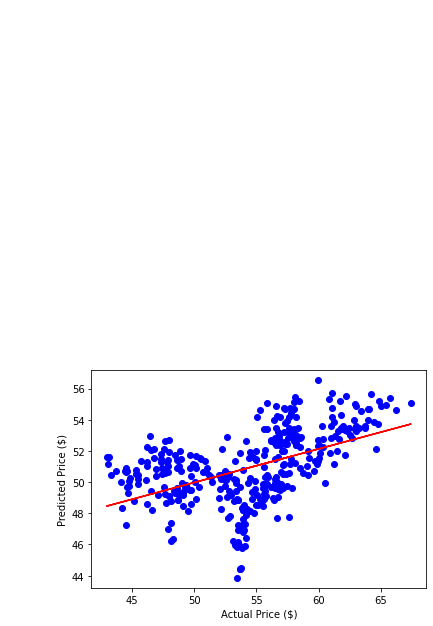

In [22]:
x_values = pred_df['Actual Close']
y_values = pred_df['Predicted Close']
(slope, intercept, rvalue,pvalue,stdeer) = linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x=x_values, y=y_values ,color="blue")
plt.plot(x_values, regress_values,"r-")
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.annotate(line_eq,(35,80), fontsize=10,color="red")

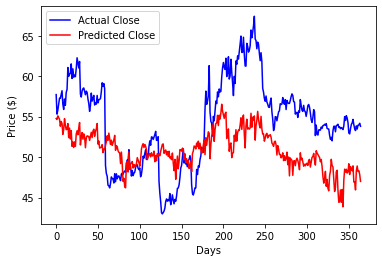

In [23]:
plt.plot(pred_df['Day'],pred_df['Actual Close'], c='b', label='Actual Close')
plt.plot(pred_df['Day'],pred_df['Predicted Close'], c='r', label='Predicted Close')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.show()

Self-testing. Not using current stock data.

In [24]:
def nn_stock_self(train_df):

  X = train_df.drop('Close', axis=1)
  y = train_df['Close']

  X_train, X_test, y_train, y_test = train_test_split(X, y)

  # Create the Keras Sequential model
  nn_model = tf.keras.models.Sequential()

  # Add our first Dense layer, including the input layer
  nn_model.add(tf.keras.layers.Dense(units=8, activation="relu", input_dim=6))

  # Add our second Dense layer, including the input layer
  nn_model.add(tf.keras.layers.Dense(units=3, activation="relu"))

  # Add the output layer that uses a probability activation function
  nn_model.add(tf.keras.layers.Dense(units=1, activation="linear"))

  # Compile the Sequential model together and customize metrics
  nn_model.compile(loss="mean_squared_error", optimizer="adam",metrics=[tf.keras.metrics.MeanSquaredError()])
  
  fit_model = nn_model.fit(X_train, y_train, epochs=150)
  
  X_pred = X_test
  y_pred = y_test
  # date = predict_df['Date']

  predictions = nn_model.predict(X_pred)
  fl_pred = [item for elem in predictions for item in elem]
  pred = {
      # 'Date': date,
      "Actual Close": y_pred,
      "Predicted Close": fl_pred
  }

  pred_df = pd.DataFrame(pred)

  pred_df = pred_df.reset_index()
  pred_df['Close Diff'] = pred_df['Predicted Close'] - pred_df['Actual Close'] 
  pred_df.loc[(pred_df['Close Diff'] < -1), 'Outcome'] = 'Loss'
  pred_df.loc[(pred_df['Close Diff'] >= -1) & (pred_df['Close Diff'] <= 1), 'Outcome'] = 'No Change'
  pred_df.loc[(pred_df['Close Diff'] > 1), 'Outcome'] = 'Gain'
  pred_df = pred_df.rename({"index":"Day"}, axis=1)
  pred_df = pred_df.sort_values('Day')

  return pred_df

In [25]:
pred_df = nn_stock_self(amd_df)

Epoch 1/150
24/24 [==============================] - 0s 1ms/step - loss: 1468.7064 - mean_squared_error: 1468.7064
Epoch 2/150
24/24 [==============================] - 0s 1ms/step - loss: 1417.2844 - mean_squared_error: 1417.2844
Epoch 3/150
24/24 [==============================] - 0s 1ms/step - loss: 1353.4402 - mean_squared_error: 1353.4402
Epoch 4/150
24/24 [==============================] - 0s 1ms/step - loss: 1279.8059 - mean_squared_error: 1279.8059
Epoch 5/150
24/24 [==============================] - 0s 1ms/step - loss: 1190.7257 - mean_squared_error: 1190.7257
Epoch 6/150
24/24 [==============================] - 0s 1ms/step - loss: 1088.2622 - mean_squared_error: 1088.2622
Epoch 7/150
24/24 [==============================] - 0s 1ms/step - loss: 963.9872 - mean_squared_error: 963.9872
Epoch 8/150
24/24 [==============================] - 0s 1ms/step - loss: 825.7359 - mean_squared_error: 825.7359
Epoch 9/150
24/24 [==============================] - 0s 1ms/step - loss: 678.2668 - 

Text(35, 80, 'y = 0.79x + 7.14')

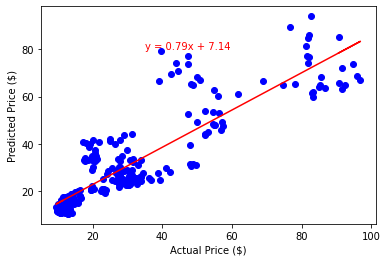

In [26]:
x_values = pred_df['Actual Close']
y_values = pred_df['Predicted Close']
(slope, intercept, rvalue,pvalue,stdeer) = linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x=x_values, y=y_values ,color="blue")
plt.plot(x_values, regress_values,"r-")
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.annotate(line_eq,(35,80), fontsize=10,color="red")

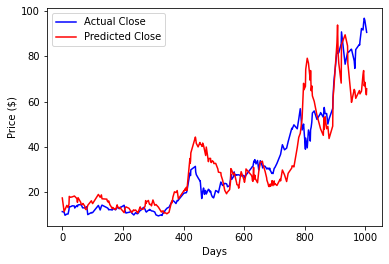

In [27]:
plt.plot(pred_df['Day'],pred_df['Actual Close'], c='b', label='Actual Close')
plt.plot(pred_df['Day'],pred_df['Predicted Close'], c='r', label='Predicted Close')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.show()

In [28]:
pred_hp_df
pred_hp_df = pred_hp_df.drop('Date',axis=1)
pred_df = nn_stock_self(pred_hp_df)

Epoch 1/150
9/9 [==============================] - 0s 2ms/step - loss: 602.6068 - mean_squared_error: 602.6068
Epoch 2/150
9/9 [==============================] - 0s 1ms/step - loss: 596.0068 - mean_squared_error: 596.0068
Epoch 3/150
9/9 [==============================] - 0s 2ms/step - loss: 588.7585 - mean_squared_error: 588.7585
Epoch 4/150
9/9 [==============================] - 0s 2ms/step - loss: 580.6947 - mean_squared_error: 580.6947
Epoch 5/150
9/9 [==============================] - 0s 2ms/step - loss: 572.0016 - mean_squared_error: 572.0016
Epoch 6/150
9/9 [==============================] - 0s 2ms/step - loss: 562.9143 - mean_squared_error: 562.9143
Epoch 7/150
9/9 [==============================] - 0s 2ms/step - loss: 553.3069 - mean_squared_error: 553.3069
Epoch 8/150
9/9 [==============================] - 0s 2ms/step - loss: 543.2916 - mean_squared_error: 543.2916
Epoch 9/150
9/9 [==============================] - 0s 2ms/step - loss: 533.0678 - mean_squared_error: 533.0678
E

Text(0, 0.5, 'Predicted Price ($)')

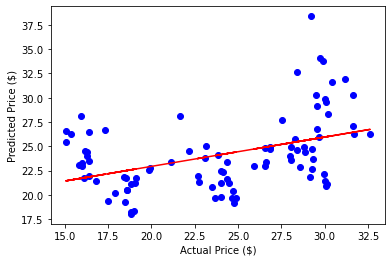

In [29]:
x_values = pred_df['Actual Close']
y_values = pred_df['Predicted Close']
(slope, intercept, rvalue,pvalue,stdeer) = linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x=x_values, y=y_values ,color="blue")
plt.plot(x_values, regress_values,"r-")
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
# plt.annotate(line_eq, fontsize=10, color="red")

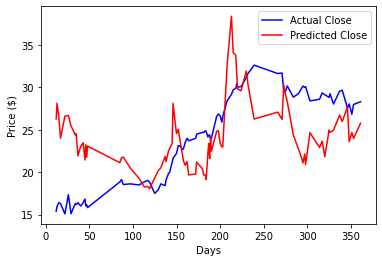

In [30]:
plt.plot(pred_df['Day'],pred_df['Actual Close'], c='b', label='Actual Close')
plt.plot(pred_df['Day'],pred_df['Predicted Close'], c='r', label='Predicted Close')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.show()